# GrIS ablation zone melt SEB causality

Author: Ziqi Yin

Last modified: 2025 Sep 22

Description: comparing causal graphs from RACMO and MAR during the historical period (1940-1969) with different significance levels

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

import cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from collections import Counter, defaultdict

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Read data

### Causal graph

In [4]:
val_matrix_RACMO_his_alphas = []
graph_RACMO_his_alphas = []
link_width_RACMO_his_alphas = []

val_matrix_MAR_his_alphas = []
graph_MAR_his_alphas = []
link_width_MAR_his_alphas = []

In [3]:
## Set parameters
max_lag = 15
pc_alphas = [0.1, 0.005]

In [5]:
for pc_alpha in pc_alphas:

    # RACMO
    data_dir = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_SEB_RACMO_noGHF_JJA_GrIS_ablation_1940_1969_daily_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_RACMO_his_alphas.append(data['val_matrix'])
    graph_RACMO_his_alphas.append(data['graph'])
    link_width_RACMO_his_alphas.append(data['link_width'])
    var_names = data['var_names'].tolist()

    # MAR
    data_dir = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_daily_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_clean_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_MAR_his_alphas.append(data['val_matrix'])
    graph_MAR_his_alphas.append(data['graph'])
    link_width_MAR_his_alphas.append(data['link_width'])

## Plot

In [6]:
def tp_plot_graph(val_matrix, graph, link_width, show_colorbar, i):

    tp.plot_graph(
        val_matrix=val_matrix,
        graph=graph,
        var_names=var_names,
        link_width=link_width,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        node_size=0.4,
        node_label_size=14,
        node_ticks=0.5,
        edge_ticks=0.5,
        link_label_fontsize=14,
        arrow_linewidth=10.0,
        #lagged_links=True  # This setting allows multiple links for different lags to be displayed
        show_colorbar=show_colorbar,
        fig_ax=(fig, axs[i])
    )

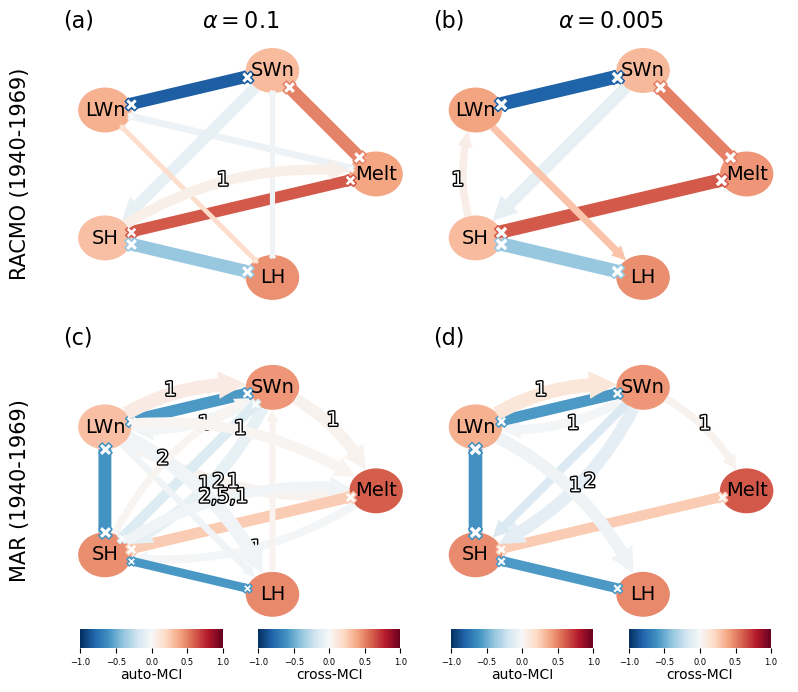

In [11]:
##
fig, axs = plt.subplots(2, 2, figsize=(8, 7))
axs = axs.flatten()  # Flatten to easily index subplots

for n in range(2):
    tp_plot_graph(val_matrix_RACMO_his_alphas[n], graph_RACMO_his_alphas[n], link_width_RACMO_his_alphas[n], False, n)
    tp_plot_graph(val_matrix_MAR_his_alphas[n], graph_MAR_his_alphas[n], link_width_MAR_his_alphas[n], True, n+2)

# Add significance level
size_title = 16
axs[0].set_title("$\\alpha = 0.1$", fontsize=size_title)
axs[0].set_title("(a)", fontsize=size_title, loc='left')
axs[1].set_title("$\\alpha = 0.005$", fontsize=size_title)
axs[1].set_title("(b)", fontsize=size_title, loc='left')
axs[2].set_title("(c)", fontsize=size_title, loc='left')
axs[3].set_title("(d)", fontsize=size_title, loc='left')

# Add model name
axs[0].text(-0.12, 0.5, "RACMO (1940-1969)", rotation=90,
           transform=axs[0].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)
axs[2].text(-0.12, 0.5, "MAR (1940-1969)", rotation=90,
           transform=axs[2].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/manuscript/'
plt.savefig(plot_dir+'figS3_causal_graph_daily_1940_1969_conservative_nofdrc_robustparcorr_taumax15_alphas.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)